In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Reshape, Conv2DTranspose, Input, UpSampling2D, concatenate
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [2]:
class DataGenerator():

    def __init__(self, train=True, batch_size = 32):
        self.batch_size = batch_size
        if train:
            self.X_path = '../data/images_processed/train'
        else:
            self.X_path = '../data/images_processed/train'

        self.files = os.listdir(self.X_path)

        self.length = len(self.files)

    def __len__(self):
        return self.length


    def __getitem__(self, index):
            filename = self.files[index]
            X = np.load(os.path.join(self.X_path, filename))
            y = X.copy()
            X[112:144, 112:144] = 0

            return X, y

In [3]:
class ExcludeFirstChannelLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        # Exclude the first channel and return the remaining channels
        output = inputs[:, :, :, 1:]
        return output

class ReplaceSliceLayer(tf.keras.layers.Layer):
    def __init__(self, slice_start, slice_end):
        super(ReplaceSliceLayer, self).__init__()
        self.slice_start = slice_start
        self.slice_end = slice_end

    def build(self, input_shape):
        # Ensure that the input shapes are compatible
        input_shape1, input_shape2 = input_shape

    def call(self, inputs):
        input1, input2 = inputs
 
        slice1 = input2[:, 112:144, 112:144, :]

        real_slice1 = input1[:, :112, :, :]
        real_slice2 = input1[:, 144:, :, :]
        real_slice3 = input1[:, 112:144, :112, :]
        real_slice4 = input1[:, 112:144, 144:, :]

        cat1 = tf.concat((real_slice3, slice1, real_slice4), axis=2)
        cat2 = tf.concat((real_slice1, cat1, real_slice2), axis=1)

        return cat2

In [4]:
def build_generator():
    inputs = Input((256, 256, 4))

    down1 = Conv2D(8, (3,3), padding='same', activation='relu')(inputs)
    maxp1 = MaxPool2D((2,2))(down1)
    down2 = Conv2D(16, (3,3), padding='same', activation='relu')(maxp1)
    maxp2 = MaxPool2D((2,2))(down2)
    down3 = Conv2D(32, (3,3), padding='same', activation='relu')(maxp2)
    maxp3 = MaxPool2D((2,2))(down3)
    down4 = Conv2D(64, (3,3), padding='same', activation='relu')(maxp3)
    maxp4 = MaxPool2D((2,2))(down4)
    down5 = Conv2D(128, (3,3), padding='same', activation='relu')(maxp4)
    maxp5 = MaxPool2D((2,2))(down5)
    down6 = Conv2D(256, (3,3), padding='same', activation='relu')(maxp5)

    conv = Conv2D(32, (3,3), padding='same', activation='relu')(down6)
    up1 = UpSampling2D(size=(2, 2))(conv)
    merge1  = concatenate([up1, down5], axis=3)
    conv1 = Conv2D(16, (3,3), padding='same', activation='relu')(merge1)
    
    up2 = UpSampling2D(size=(2, 2))(conv1)
    merge2  = concatenate([up2, down4], axis=3)
    conv2 = Conv2D(8, (3,3), padding='same', activation='relu')(merge2)
    
    up3 = UpSampling2D(size=(2, 2))(conv2)
    merge3  = concatenate([up3, down3], axis=3)
    conv3 = Conv2D(3, (3,3), padding='same', activation='relu')(merge3)
    
    up4 = UpSampling2D(size=(2, 2))(conv3)
    merge4  = concatenate([up4, down2], axis=3)
    conv4 = Conv2D(3, (3,3), padding='same', activation='relu')(merge4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5  = concatenate([up5, down1], axis=3)
    conv5 = Conv2D(3, (3,3), padding='same', activation='relu')(merge5)
    

    exclude_first_channel_layer = ExcludeFirstChannelLayer()

    sliceLayer = ReplaceSliceLayer(0, 0)
    ex = exclude_first_channel_layer(inputs)
    outputs = sliceLayer((ex, conv5))

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Discriminator model
def build_discriminator():
    model = Sequential([
        Conv2D(4, (5,5), padding='same', activation='relu', input_shape=(256, 256, 3)),
        Conv2D(8, (5,5), padding='same', activation='relu', strides=(2,2)),
        Conv2D(16, (5,5), padding='same', activation='relu', strides=(2,2)),
        Flatten(),
        Dense(128),
        Dense(16),
        Dense(1, activation='sigmoid')
    ])
    
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [50]:
generator = build_generator()
generator.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 256, 256, 8)          296       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_38 (MaxPooli  (None, 128, 128, 8)          0         ['conv2d_98[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_99 (Conv2D)          (None, 128, 128, 16)         1168      ['max_pooling2d_38[0][0]

In [5]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 4)       304       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       808       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8388736   
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [6]:
discriminator.save('discriminator.h5')

c:\Users\krzysztof\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
gan = build_gan(generator, discriminator)
gan.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 256, 256, 3)       498107    
                                                                 
 sequential_12 (Sequential)  (None, 1)                 8395145   
                                                                 
Total params: 8893252 (33.93 MB)
Trainable params: 8893252 (33.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
batch_size = 32
dataGenerator = DataGenerator(batch_size=batch_size)


def data_generator_function():
    for i in range(len(dataGenerator)):
        yield dataGenerator[i]


dataset = tf.data.Dataset.from_generator(
    data_generator_function,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32)
    )
)


batched_dataset = dataset.batch(dataGenerator.batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
def compile_discriminator(discriminator):
    custom_optimizer = Adam()
    discriminator.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

def compile_gan(gan):
    custom_optimizer = Adam()
    gan.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

def compile_generator(generator):
    custom_optimizer = Adam()
    generator.compile(loss='mse', optimizer=custom_optimizer)

def generate_noise(batch_size, latent_dim):
    return np.random.normal(0, 1, size=(batch_size, latent_dim))

def train_gan(generator, discriminator, gan, epochs, batch_size):
    i = 0
    print(i)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    g_loss = 0
    for epoch in range(epochs):
        for batch in batched_dataset:
            cut_images, real_imgs = batch
            print(cut_images.shape)

            if cut_images.shape[0] != batch_size:
                continue


            noise = np.random.normal(0, 1, size=(batch_size, 256, 256, 1))
            images_with_noise = np.concatenate((noise, cut_images), axis=-1)

            fake_imgs = generator.predict(images_with_noise)


            if i % 100 == 0:
                plt.imshow(real_imgs[0])
                plt.show()
                plt.imshow(fake_imgs[0])
                plt.show()
                
            i += 1

            if g_loss < 0.1:
                discriminator.trainable = True
                d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
                d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            valid_labels = np.ones((batch_size, 1))

            if d_loss[0] < 0.1 or g_loss > 0.1:
                discriminator.trainable = False
                generator.train_on_batch(images_with_noise, real_imgs)
                g_loss = gan.train_on_batch(images_with_noise, valid_labels)

            print(f"Epoch {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


epochs = 40

# Build and compile the models
compile_discriminator(discriminator)
compile_gan(gan)
compile_generator(generator)

# Train the GAN
train_gan(generator, discriminator, gan, epochs, batch_size)


In [55]:
generator.save('generator2.h5')

c:\Users\krzysztof\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


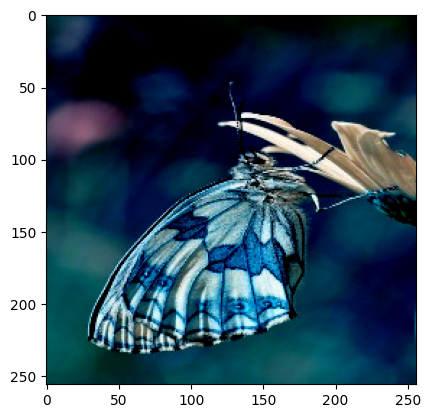

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


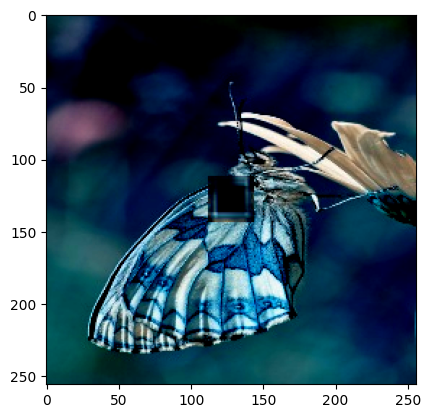

In [56]:
for batch in batched_dataset:
    X_test, y_test = batch
    plt.imshow(y_test[0])
    plt.show()
    noise = np.random.normal(0, 1, size=(32, 256, 256, 1))
    X_test_with_noise = np.concatenate((noise, X_test), axis=-1)
    X_filled = generator.predict(X_test_with_noise)
    plt.imshow(X_filled[0])
    plt.show()
    break